<a href="https://colab.research.google.com/github/freethechicken/pbh_simulations/blob/main/GRF1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import imageio
import os
from scipy.special import erf

# 1. Define functions

1. **Random Sampling (CPU)**:
The full list of all possible sampling in numpy can be found in the following [link](https://numpy.org/doc/1.16/reference/routines.random.html).
2. **Random Field Simulations (GPU)**:
GPU simulations of the random field are generated by [Cupy](https://cupy.dev/).

In [39]:
# @title 1.1 Random Sampling (CPU)
def gaussian_white_noise(pixel, mean, std_dev):

    # Generate a 2D grid of white noise from a normal pdf
    white_noise = np.random.normal(mean, std_dev, (pixel, pixel))
    return white_noise

def exponential_white_noise(pixel, decay_rate):

    # Generate a 2D grid of white noise from an exponentially decaying pdf
    white_noise = np.random.exponential(1/decay_rate, (pixel, pixel))
    return white_noise

def poisson_white_noise(pixel, expected_occurrences_rate):

    # Generate a 2D grid of white noise from an exponentially decaying pdf
    white_noise = np.random.poisson(expected_occurrences_rate, (pixel, pixel))
    return white_noise

def gaussian_white_noise_3d(pixel, z_pixel, mean, std_dev):

    # Generate a 3D grid of white noise from a normal distribution
    white_noise = np.random.normal(mean, std_dev, (pixel, pixel, z_pixel))
    return white_noise

def exponential_white_noise_3d(pixel, z_pixel, decay_rate):

    # Generate a 3D grid of white noise from an exponentially decaying pdf
    white_noise = np.random.exponential(1/decay_rate, (pixel, pixel, z_pixel))
    return white_noise

def poisson_white_noise_3d(pixel, z_pixel, expected_occurrences_rate):

    # Generate a 3D grid of white noise from an exponentially decaying pdf
    white_noise = np.random.poisson(expected_occurrences_rate, (pixel, pixel, z_pixel))
    return white_noise

In [40]:
# @title 1.2 Random Field Simulations (GPU)
def gpu_grf_2d(white_noise, pixel, amplitude, k_power):
    # Transfer white noise to GPU
    white_noise_gpu = cp.asarray(white_noise)

    # 2D Fast Fourier transform of the white noise
    fft_white_noise = cp.fft.fft2(white_noise_gpu)

    # Generating FFT momentum
    kx = cp.fft.fftfreq(pixel)*pixel
    ky = cp.fft.fftfreq(pixel)*pixel

    # Genearting FFT momentum 2D array
    kx_grid, ky_grid = cp.meshgrid(kx, ky)
    #k_grid = np.meshgrid(kx, ky)

    # Norm of k
    k_norm =  cp.sqrt( kx_grid**2 + ky_grid**2 ) # k = sqrt( kx^2 + ky^2 )
    k_norm[0][0] = cp.inf # Regularize divergence at k=0

    # Power Spectrum P_k
    power_spectrum = amplitude*(((2 * cp.pi/pixel)*k_norm)**(-1*k_power))  # P(k)=amplitude/k^{power},

    power_spectrum_gpu = cp.asarray(power_spectrum)
    # Multiply the power spectrum with the transformed white noise using GPU-accelerated FFT
    fourier_amplitudes_sqrt_gpu = cp.sqrt(power_spectrum_gpu) * cp.fft.fft2(white_noise_gpu)

    # Perform inverse Fourier transform on GPU to obtain the Gaussian random field
    gaussian_random_field_gpu = cp.fft.ifft2(fourier_amplitudes_sqrt_gpu).real

    # Transfer the result back to CPU
    gaussian_random_field = cp.asnumpy(gaussian_random_field_gpu)

    return gaussian_random_field, white_noise


def gpu_grf_3d(white_noise, pixel, z_pixel, amplitude, k_power):
    # Transfer white noise to GPU
    white_noise_gpu = cp.asarray(white_noise)

    # 3D Fast Fourier transform of the white noise
    fft_white_noise = cp.fft.fftn(white_noise_gpu)

    # Generating FFT momentum
    kx = cp.fft.fftfreq(pixel)*pixel
    ky = cp.fft.fftfreq(pixel)*pixel
    kz = cp.fft.fftfreq(z_pixel)*z_pixel

    # Genearting FFT momentum 3D array
    kx_grid, ky_grid, kz_grid = cp.meshgrid(kx, ky, kz)
    # k_grid = np.meshgrid(kx, ky, kz)

    # Norm of k
    k_norm =  cp.sqrt( kx_grid**2 + ky_grid**2 + kz_grid**2 ) # k = sqrt( kx^2 + ky^2  + kz^2 )
    k_norm[0][0] = cp.inf # Regularize divergence at k=0

    # Power Spectrum P_k
    power_spectrum = amplitude*(((2 * cp.pi/pixel)*k_norm)**(-1*k_power))  # P(k)=amplitude/k^{power},

    # Multiply the power spectrum with the transformed white noise to get the realization of the spectrum
    fourier_amplitudes_sqrt = cp.sqrt(power_spectrum)*fft_white_noise


    # Perform inverse Fourier transform to obtain the Gaussian random field in the spatial domain
    gaussian_random_field = cp.fft.ifftn(fourier_amplitudes_sqrt).real

    # Transfer the result back to CPU
    gaussian_random_field = cp.asnumpy(gaussian_random_field)

    return gaussian_random_field, white_noise

# Call the function with your 'fig' array and 'ratio' value


In [41]:
# @title Random Fields Simulation (CPU)
def gaussian_random_field_2d(white_noise, pixel, amplitude, k_power):

    # 2D Fast Fourier transform of the white noise
    fft_white_noise = np.fft.fft2(white_noise)

    # Generating FFT momentum
    kx = np.fft.fftfreq(pixel)*pixel
    ky = np.fft.fftfreq(pixel)*pixel

    # Genearting FFT momentum 2D array
    kx_grid, ky_grid = np.meshgrid(kx, ky)
    #k_grid = np.meshgrid(kx, ky)

    # Norm of k
    k_norm =  np.sqrt( kx_grid**2 + ky_grid**2 ) # k = sqrt( kx^2 + ky^2 )
    k_norm[0][0] = np.inf # Regularize divergence at k=0

    # Power Spectrum P_k
    power_spectrum = amplitude*(((2 * np.pi/pixel)*k_norm)**(-1*k_power))  # P(k)=amplitude/k^{power},

    # Multiply the power spectrum with the transformed white noise to get the realization of the spectrum
    fourier_amplitudes_sqrt = np.sqrt(power_spectrum)*fft_white_noise

    # Perform inverse Fourier transform to obtain the Gaussian random field in the spatial domain
    gaussian_random_field = np.fft.ifft2(fourier_amplitudes_sqrt).real

    return gaussian_random_field, white_noise

def gaussian_random_field_3d(white_noise, pixel, z_pixel, amplitude, k_power):
    # 3D Fast Fourier transform of the white noise
    fft_white_noise = np.fft.fftn(white_noise)

    # Generating FFT momentum
    kx = np.fft.fftfreq(pixel)*pixel
    ky = np.fft.fftfreq(pixel)*pixel
    kz = np.fft.fftfreq(z_pixel)*z_pixel

    # Genearting FFT momentum 3D array
    kx_grid, ky_grid, kz_grid = np.meshgrid(kx, ky, kz)
    # k_grid = np.meshgrid(kx, ky, kz)

    # Norm of k
    k_norm =  np.sqrt( kx_grid**2 + ky_grid**2 + kz_grid**2 ) # k = sqrt( kx^2 + ky^2  + kz^2 )
    k_norm[0][0] = np.inf # Regularize divergence at k=0

    # Power Spectrum P_k
    power_spectrum = amplitude*(((2 * np.pi/pixel)*k_norm)**(-1*k_power))  # P(k)=amplitude/k^{power},

    # Multiply the power spectrum with the transformed white noise to get the realization of the spectrum
    fourier_amplitudes_sqrt = np.sqrt(power_spectrum)*fft_white_noise


    # Perform inverse Fourier transform to obtain the Gaussian random field in the spatial domain
    gaussian_random_field = np.fft.ifftn(fourier_amplitudes_sqrt).real
    return gaussian_random_field, white_noise


def gaussian_to_exp(x, lam):
    mu = np.mean(x)
    sigma = np.std(x)
    xu = 0.5 * (1 + erf((x - mu) / (np.sqrt(2) * sigma)))
    return -1/lam  * np.log(1 - xu)

def plot_grf_2d(fig, ratio):
    # Normalize the field values
    ratio = 0.75
    fig = fig/(ratio*np.max(fig))

    # Plot the white noise grid as a grayscale image
    plt.imshow(fig, cmap='rainbow', clim=[-1, 1])
    #BrBG bwr rainbow
    plt.colorbar()
    plt.xlabel('pixels')
    plt.ylabel('pixels')
    plt.title('Gaussian Random Field')
    plt.figure(figsize=(20, 20))
    plt.show()

def plot_over_dense_by_ratio_2d(fig, ratio):
    ratio = 0.5
    cut_off = ratio*np.max(fig)

    # Create a boolean mask for elements greater than the cutoff
    mask = np.abs(fig) > cut_off
    # Find the indices of elements greater than the cutoff
    overdense_position = np.where(mask, fig, 0)

    # Normalize the field values
    # Plot the white noise grid as a grayscale image
    contrast_ratio =1
    overdense_position = overdense_position/(contrast_ratio*np.max(overdense_position))

    plt.imshow(overdense_position, cmap='rainbow', clim=[-1, 1])
    #BrBG bwr rainbow
    plt.colorbar()
    plt.xlabel('pixels')
    plt.ylabel('pixels')
    plt.title(f'Filtered GRF, with Cut off ratio = {ratio}')
    plt.figure(figsize=(20, 20))
    plt.show()

def over_dense_fraction_2d(grf,pixel):
    # An array of ratios ranging from 0 to 1
    test_ratios = np.linspace(0, 1, num=100)

    # Initialize an empty list
    overdense_numbers = []
    # Calculate overdense numbers for different ratios
    for ratio in test_ratios:
        # Define the cut off values
        cut_off = ratio * np.max(grf)
        mask = np.abs(grf) > cut_off
        overdense_number = np.sum(mask)/(pixel**2)
        overdense_numbers.append(overdense_number)

    # Plot overdense numbers against ratios
    plt.figure(figsize=(6, 6))
    plt.plot(test_ratios, overdense_numbers, color='b', linewidth=2)
    plt.xlabel('Ratio')
    plt.ylabel('Precentages of Overdense Elements')
    plt.title('Precentages of Overdense Elements vs. Ratio')
    plt.grid(True)


def plot_over_dense_by_ratio_3d(fig, ratio):
    ratio = 0.5
    cut_off = ratio*np.max(fig)

    # Create a boolean mask for elements greater than the cutoff
    mask = np.abs(fig) > cut_off
    # Find the indices of elements greater than the cutoff
    overdense_position = np.where(mask, fig, 0)
    return(overdense_position)
    # Normalize the field values
    # Plot the white noise grid as a grayscale image
    #contrast_ratio =1
    #overdense_position = overdense_position/(contrast_ratio*np.max(overdense_position))

    #plt.imshow(overdense_position, cmap='rainbow', clim=[-1, 1])
    #BrBG bwr rainbow
    #plt.colorbar()
    #plt.xlabel('pixels')
    #plt.ylabel('pixels')
    #plt.title(f'Filtered GRF, with cut off ratio = {ratio}')
    #plt.figure(figsize=(20, 20))
    #plt.show()

def over_dense_fraction_3d(grf,pixel,z_pixel):
    # An array of ratios ranging from 0 to 1
    test_ratios = np.linspace(0, 1, num=100)

    # Initialize an empty list
    overdense_numbers = []
    # Calculate overdense numbers for different ratios
    for ratio in test_ratios:
        # Define the cut off values
        cut_off = ratio * np.max(grf)
        mask = np.abs(grf) > cut_off
        overdense_number = np.sum(mask)/(pixel*pixel*z_pixel)
        overdense_numbers.append(overdense_number)

    # Plot overdense numbers against ratios
    plt.figure(figsize=(6, 6))
    plt.plot(test_ratios, overdense_numbers, color='b', linewidth=2)
    plt.xlabel('Ratio')
    plt.ylabel('Precentages of Overdense Elements')
    plt.title('Precentages of Overdense Elements vs. Ratio')
    plt.grid(True)



def gaussian_to_exp(x, lam):
    mu = np.mean(x)
    sigma = np.std(x)
    xu = 0.5 * (1 + erf((x - mu) / (np.sqrt(2) * sigma)))
    return -1/lam  * np.log(1 - xu)

# 2. **Main**

### References
The entire notebook is constructed out of [the following website](https://garrettgoon.com/gaussian-fields/).


### Procedure

1. Generate the (normal distributed) white noise field $\langle n(\vec x) n(\vec y) \rangle \propto \delta^3(\vec x, \vec y)$.

2. Perform Fast Fourier transform to obtain noise field of unit amplitude $\langle n(\vec k) n(-\vec k) \rangle = 1$

3. Obtain the fourier ampltide by multiplying the white noise field with the
 power spectrum:
$\langle \phi(\vec k)\phi(-\vec k)\rangle'=\langle n(\vec x) n(\vec y) \rangle \times P(k)$ for $P(k) \equiv {A}{ \lvert k \rvert^{-d}}$.

4. Inverse Fast Fourier transform to obtain the gaussian field.

### Parameters:

- `amplitude`: amplitude of spectrum $A$
- `k_power` : power law of the spectrum $d$
- `pixel` : pixels, size of the plots
- `mean` : mean of the gaussian distribution
- `std_dev` : standard deviation of the gaussian distribution
- `decay_rate` : decay rate of the exponential distribution
- `expected_occurrences_rate ` : expected occurrences rate of the poisson distribution

In [42]:
# @title Parameters
amplitude = 1 # amplitude of the power spectrum
k_power = 3 # power of k in the power spectrum

# Define the size of the square grid
pixel = 2**10  # 2^8 = 256
z_pixel = 2**6# Reduce ram usage

# Parameters for the normal distribution
mean = 0      # Mean
std_dev = 1   # Standard deviation
# Parameters for exponential decay
decay_rate = 1
# Parameters for poisson distribution
expected_occurrences_rate = 10

## 2.1 2D Model

In [43]:
# @title Run 2D Model (GPU)
grf, white_noise  = gpu_grf_2d(gaussian_white_noise(pixel,mean,std_dev), pixel, amplitude, k_power)
# grf, white_noise  = gpu_grf_2d(exponential_white_noise(pixel,decay_rate), pixel, amplitude, k_power)

In [44]:
# @title Run 2D Model (CPU) [Inactive]
# Run the model

#grf, white_noise = gaussian_random_field_2d(poisson_white_noise(pixel, expected_occurrences_rate), pixel, amplitude, k_power) # poisson white noise
#grf, white_noise = gaussian_random_field_2d(exponential_white_noise(pixel,decay_rate), pixel, amplitude, k_power) # exponential white noise
#grf, white_noise = gaussian_random_field_2d(gaussian_white_noise(pixel,mean,std_dev), pixel, amplitude, k_power) # gaussian white noise

# white noise sample: gaussian_white_noise, exponential_white_noise


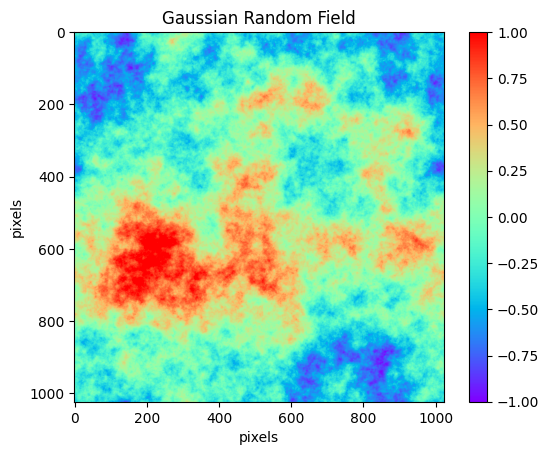

<Figure size 2000x2000 with 0 Axes>

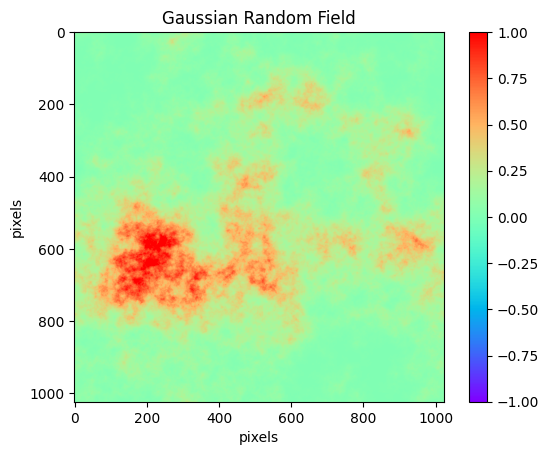

<Figure size 2000x2000 with 0 Axes>

In [45]:
# @title Plot 2D figures
plot_grf_2d(grf, ratio=0.66)

#plot_over_dense_by_ratio_2d(grf, ratio=0.45)
#over_dense_fraction_2d(grf,pixel)

exprf = gaussian_to_exp(grf, 1)

plot_grf_2d(exprf, ratio=0.66)


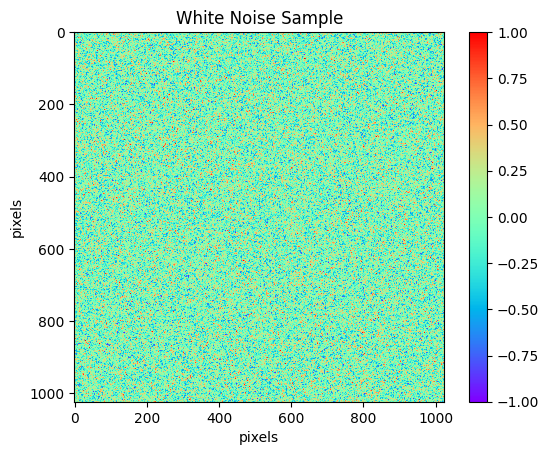

<Figure size 2000x2000 with 0 Axes>

In [35]:
# @title Noise samples
# Plot the white noise grid as a grayscale image
# plt.imshow(white_noise, cmap='rainbow', clim=[0, 2*expected_occurrences_rate])
plt.imshow(white_noise, cmap='rainbow', clim=[-std_dev , std_dev ])
#plt.imshow(white_noise, cmap='rainbow', clim=[-2/decay_rate , 2/decay_rate ])
#BrBG bwr rainbow
plt.colorbar()
plt.xlabel('pixels')
plt.ylabel('pixels')
plt.title('White Noise Sample')
plt.figure(figsize=(20, 20))
plt.show()

# 2.2 3D Model

In [36]:
# @title Run 3D Model (CPU) [Inactive]
#grf, white_noise_3d = gaussian_random_field_3d(gaussian_white_noise_3d(pixel, z_pixel, mean, std_dev), pixel, z_pixel, amplitude, k_power)

In [46]:
# @title Run 3D Model (GPU)
grf, white_noise_3d = gpu_grf_3d(gaussian_white_noise_3d(pixel, z_pixel, mean, std_dev), pixel, z_pixel, amplitude, k_power)

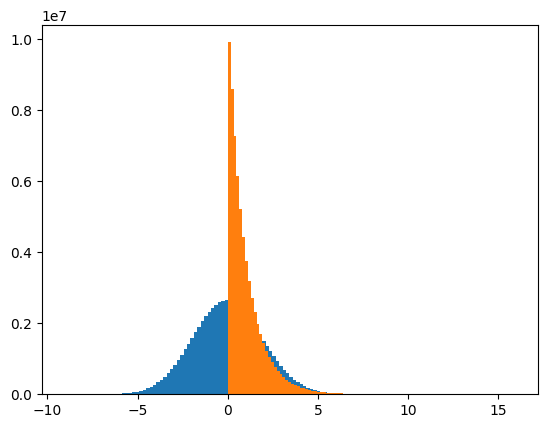

In [47]:
plt.hist(grf.flatten(),bins=100);
exprf = gaussian_to_exp(grf, 1)
plt.hist(exprf.flatten(),bins=100);

In [ ]:
# @title Video for 3D Visualization
# Normalize the field values
ratio = 0.66 # 0.0001
grf = grf / (ratio * np.max(grf))

# Create a list to store individual frames for the GIF
frames = []

# Loop through the third dimension (z-axis) of the grf array
for z in range(grf.shape[2]):
    # Extract 2D slice at the current z-coordinate
    grf_slice = grf[:, :, z]

    # Plot the 2D slice
    plt.imshow(grf_slice, cmap='rainbow', clim=[-1, 1])
    plt.colorbar()
    plt.xlabel('pixels')
    plt.ylabel('pixels')
    plt.title(f'Gaussian Random Field (z = {z})')
    # Save the current plot as a frame
    plt.savefig(f'frame_{z:04d}.png')
    plt.close()  # Close the plot for the next iteration

    # Append the saved frame to the frames list
    frames.append(f'frame_{z:04d}.png')

# Create a GIF from the saved frames using imageio
#with imageio.get_writer('grf_animation.gif', mode='I', duration=0.001) as writer:
with imageio.get_writer('grf_animation.mp4', format='FFMPEG', mode='I', fps=30 ) as writer:
    for frame in frames:
        image = imageio.imread(frame)
        writer.append_data(image)
        # Remove the temporary frame files after appending to the GIF
        os.remove(frame)

<ipython-input-46-d6099784e491>:31: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(frame)


In [ ]:
# @title Video for 3D Visualization of Overdense regime
# Normalize the field values
grf_over_dense = plot_over_dense_by_ratio_3d(grf,0.33)

grf_over_dense = grf_over_dense / (np.max(grf_over_dense))
# Create a list to store individual frames for the GIF
frames = []

# Loop through the third dimension (z-axis) of the grf array
for z in range(grf_over_dense.shape[2]):
    # Extract 2D slice at the current z-coordinate
    grf_over_dense_slice = grf_over_dense[:, :, z]

    # Plot the 2D slice
    plt.imshow(grf_over_dense_slice, cmap='rainbow', clim=[-1, 1])
    plt.colorbar()
    plt.xlabel('pixels')
    plt.ylabel('pixels')
    plt.title(f'Gaussian Random Field (z = {z})')
    # Save the current plot as a frame
    plt.savefig(f'frame_{z:04d}.png')
    plt.close()  # Close the plot for the next iteration

    # Append the saved frame to the frames list
    frames.append(f'frame_{z:04d}.png')

# Create a GIF from the saved frames using imageio
#with imageio.get_writer('grf_animation.gif', mode='I', duration=0.001) as writer:
with imageio.get_writer('od_grf_animation.mp4', format='FFMPEG', mode='I', fps=30 ) as writer:
    for frame in frames:
        image = imageio.imread(frame)
        writer.append_data(image)
        # Remove the temporary frame files after appending to the GIF
        os.remove(frame)

<ipython-input-47-d4c0f2425dd8>:31: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(frame)
